In [1]:
import os
import itertools

import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np
import scipy
from scipy import linalg
from scipy.io import loadmat
from sklearn import mixture

from gmm_lbd import GmmManager

%matplotlib inline



In [2]:
# datas taken from calinon matlab code GMM-GMR-v2 
data1 = loadmat('records/data1.mat')['Data'].transpose( )
print data1.shape
data2_a = loadmat('records/data2_a.mat')['Data'].transpose()
print data2_a.shape
data2_b = loadmat('records/data2_b.mat')['queryData'].transpose()
print data2_b.shape
data3_a = loadmat('records/data3_a.mat')['Data1'].transpose()
print data3_a.shape
data3_b = loadmat('records/data3_b.mat')['Data2'].transpose()
print data3_b.shape

(300, 3)
(300, 4)
(100, 2)
(300, 3)
(300, 3)


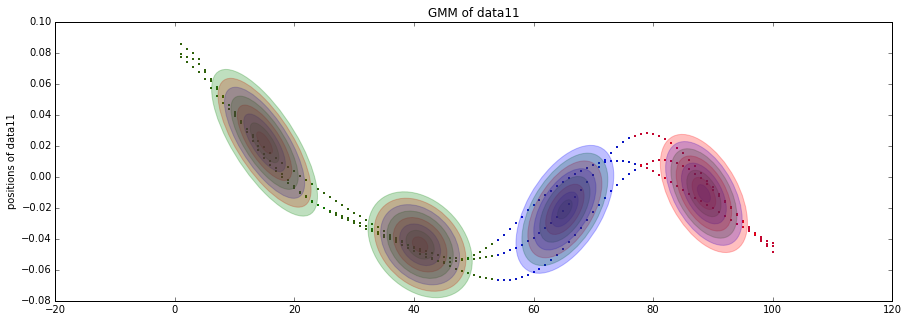

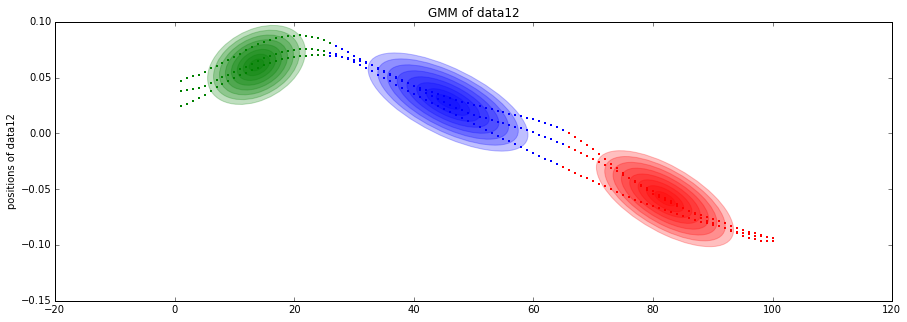

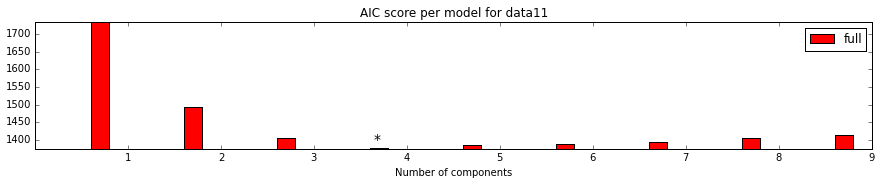

In [4]:
manager = GmmManager(n_components_range=range(1,10))
manager.add_dataset(data1[:,[0,1]],name='data11')
#manager.add_dataset(data1,name='data11')

manager.add_dataset(data1[:,[0,2]],name='data12')

manager.plot_ellipses_and_samples('data11')
#manager.plot_regression('data11')

manager.plot_ellipses_and_samples('data12')
manager.plot_bics('data11')


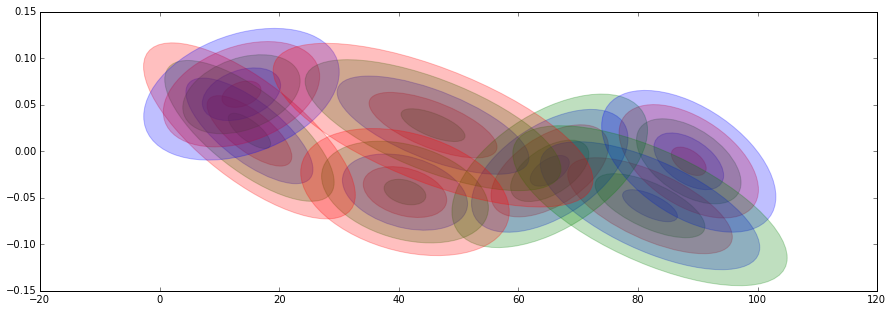

In [7]:
X = manager.datasets['data11']
gmm1, gmm2 = manager.gmms['data11'], manager.gmms['data12']
means1, means2 = gmm1.means_, gmm2.means_
covars1, covars2 = gmm1.covars_, gmm2.covars_
cov = np.concatenate((covars1, covars2))
mean = np.concatenate((means1, means2))

manager.plot_ellipses(means=mean, covars=cov,xlim=(-20,120), ylim=(-0.15,0.15))

In [ ]:
manager.add_dataset(data3_a[:,[0,1]],name='data3a')
manager.add_dataset(data3_b[:,[0,1]],name='data3b')
manager.plot_bics('data3a')
manager.plot_ellipses_and_samples('data3a')



In [ ]:
manager.plot_bics('data3b')
manager.plot_ellipses_and_samples('data3b')
manager.plot_regression('data3b')



In [ ]:
gmm_sp.plot_regression(X_test[:,np.newaxis])

In [8]:
np.linspace(min(X[:,0]), max(X[:,0]), 10)



array([   1.,   12.,   23.,   34.,   45.,   56.,   67.,   78.,   89.,  100.])

In [ ]:
expected_weights.dot(expected_covars.T[0].T)

In [15]:
from sklearn.utils.extmath import pinvh

def product(self, gmm2, X):
    """Predict a generalized trajectory from two independant constraints.

    """
    means1, covars1 = self.regression(X)
    means2, covars2 = gmm2.regression(X)

    generalized_mean = np.empty_like(means1)
    generalized_covar = np.empty_like(covars1)
    for i, (mean1, covar1, mean2, covar2) in enumerate(zip(means1, covars1, means2, covars2)):
        generalized_mean[i] = pinvh(pinvh(covar1) + pinvh(covar2)).dot(
            pinvh(covar1).dot(mean1) + pinvh(covar2).dot(mean2))
        generalized_covar[i] = pinvh(pinvh(covar1) + pinvh(covar2))
    return generalized_mean, generalized_covar

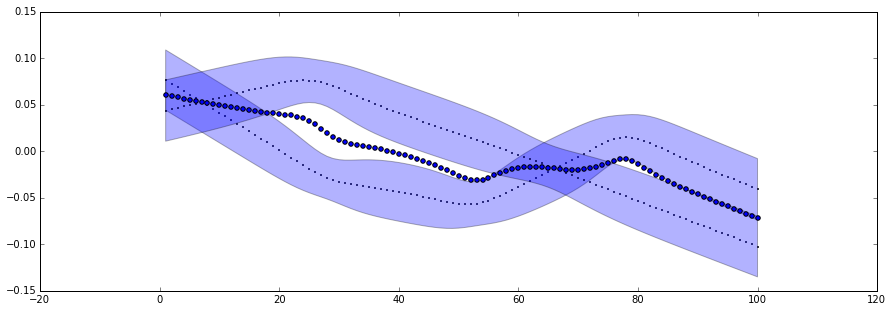

In [16]:
x = np.linspace(min(X[:,0]), max(X[:,0]), 100)

m, c = product(gmm1, gmm2, x)
plt.figure(figsize=(15, 5))
ax = plt.subplot(111)
gmm1.plot_regression(x, ax=ax)
gmm2.plot_regression(x, ax=ax)
ax.scatter(x,m),
ax.fill_between()

In [ ]:
X[:,0]

In [ ]:
expData = np.empty_like(datas)
expData[0,:] = np.linspace(min(datas[0,:]), max(datas[0,:]), 100)


In [ ]:
np.linspace(min(datas[0,:]), max(datas[0,:]), 10)